[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 5.1076e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


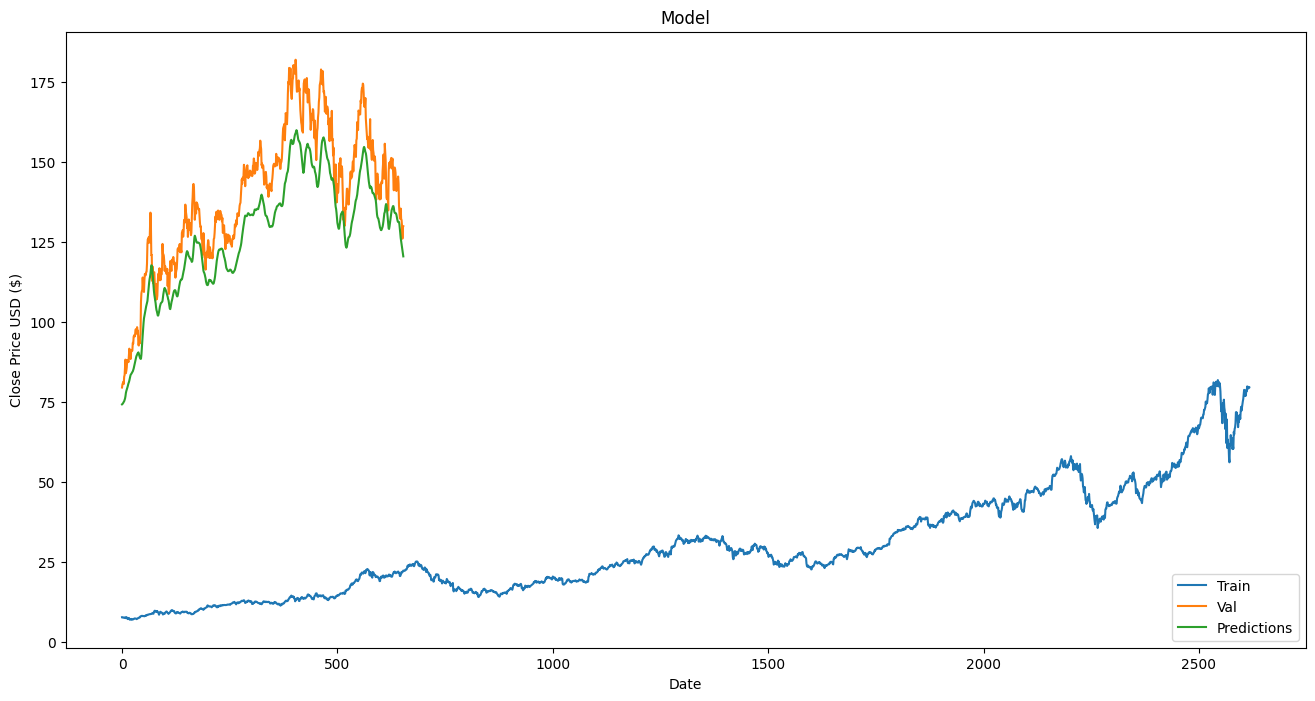

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

# Download stock data
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')

# Preparing the data

# Select the 'Close' price column for closing stock prices of each day
data = stock_data['Close'].values
# Reshape the data for model
data = data.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * 0.8))  # 80% for training, 20% for testing

train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60:, :]

# Create the training dataset
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Create the testing dataset
x_test = []
y_test = data[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to numpy array
x_test = np.array(x_test)

# Reshape the data for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid = pd.DataFrame(valid, columns=['Close'])
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
